In [1]:
import pandas as pd
import os
import numpy as np

In [2]:
result_files = os.listdir('mislead_second_order')
result_files

['deepseek-ai_DeepSeek-R1_50.csv',
 'deepseek-ai_DeepSeek-R1_10.csv',
 'deepseek-ai_DeepSeek-R1_60.csv',
 'holes_gpt-4_80.csv',
 'deepseek-ai_DeepSeek-R1_40.csv',
 'gpt-4_20.csv',
 'gpt-4_40.csv',
 'holes_gpt-4_30.csv',
 'gpt-4_5.csv',
 'holes_gpt-4_40.csv',
 'deepseek-ai_DeepSeek-R1_30.csv',
 'holes_gpt-4_20.csv',
 'holes_gpt-4_10.csv',
 'holes_gpt-4_70.csv',
 'holes_gpt-4_50.csv',
 'deepseek-ai_DeepSeek-R1_70.csv',
 'deepseek-ai_DeepSeek-R1_80.csv',
 'deepseek-ai_DeepSeek-R1_20.csv',
 'gpt-4_60.csv',
 'gpt-4_30.csv',
 'gpt-4_10.csv',
 'gpt-4_80.csv',
 'gpt-4_70.csv',
 'gpt-4_50.csv',
 'deepseek-ai_DeepSeek-R1_5.csv',
 'holes_gpt-4_60.csv',
 'holes_gpt-4_5.csv']

In [3]:
def compute_score_unsure(label, response, starting_loc='hallway'):
    #label = label.split(',')[0][2:-1]
    base = f'{label.split("_")[0]}_' if not label.startswith(starting_loc) else label
    response = response.split("\n")[-1]
    response = response.lower().replace("_",' ')
    if response.count(base) <= 1:
        return str(label in response or label.replace('_'," ") in response or 
                   label.replace('_',"") in response or
                   (starting_loc
                    in label and starting_loc in response) or
                   label.replace(" ",'') in response)
    elif 'Therefore,' in response:
        response = response.split('Therefore,')[-1]
        return str(label in response or label.replace('_'," ") in response or label.replace('_',"") in response or (starting_loc in label and starting_loc in response))
    return f'{response}, {label}'

# def compute_score_unsure_r1(label, response):
    
#     #label = label.split(',')[0][2:-1]
#     # base = label.split("_")[0] if not label.startswith(sim.locations[-1]) else label
#     if 'Answer:' in response:
#         return str(label in response.split('Answer:')[-1] or label.replace('_',' ') in response.split('Answer:')[-1])
#     elif 'A:' in response:
#         return str(label in response.split('A:')[-1] or label.replace('_',' ') in response.split('A:')[-1])
#     elif 'Conclusion:' in response:
#         return str(label in response.split('Conclusion:')[-1] or label.replace('_',' ') in response.split('Conclusion:')[-1])
#     else:

#         return f'{response}, {label}'

def compute_score_unsure_r1(label, response):
    
    base = f'{label.split("_")[0]}_' if not label.startswith('hallway') else label
    response = response.split("\n")[-1]
    response = response.lower().replace("_",' ')
    if response.count(base) <= 1:
        return str(label in response or label.replace('_'," ") in response or 
                   label.replace('_',"") in response or
                   ("hallway" in label and "hallway" in response) or
                   label.replace(" ",'') in response)
    elif 'Therefore,' in response:
        response = response.split('Therefore,')[-1]
        return str(label in response or label.replace('_'," ") in response or label.replace('_',"") in response or ("hallway" in label and "hallway" in response))
    return f'{response}, {label}'


def get_p2_steps(story, p2):
    story = story.split('. ')[10:]
    filtered_story = [s for s in story if s.startswith(p2)]
    p2_locs = [fs.split(' ')[-1] for fs in filtered_story]
    return p2_locs

def matching_response(response, steps, is_correct):
    if is_correct:
        return -1
    for idx, step in enumerate(steps):
        score = compute_score_unsure(step, response)
        if score == 'True':
            return idx
    return -2

def display_model_collapse(dataframe):
    dataframe['P2_Locs'] = dataframe.apply(lambda x: get_p2_steps(x['Story'], x['P2']), axis=1)
    dataframe['Correct'] = dataframe.apply(lambda x: "True" == compute_score_unsure(x['Label'], x['TOM Responses']), axis=1)
    dataframe['Matching'] = dataframe.apply(lambda x: matching_response(x['TOM Responses'], x['P2_Locs'], x['Correct']), axis=1)
    print(dataframe['Matching'].value_counts())
    

In [4]:
compute_score_unsure("the hallway", "Hallway")


'True'

In [6]:
folder = 'mislead_second_order'
file = result_files[-3]
#print(file)
df = pd.read_csv(f"{folder}/{file}")
df.head()

,Unnamed: 0,Story,Label,P1,P2,Last,CP_Loc,TOM Responses
0,0,Danny enters room_4. Edward enters room_2. Fra...,the_hallway,"Danny,Alice",Bob,room_4,NaN,"<think>\nOkay, let's try to figure out where D..."
1,0,Danny enters room_4. Frank enters room_1. Dann...,room_5,"Charlie,Alice",Georgia,room_4,NaN,"<think>\nOkay, let's try to figure out where C..."
2,0,Danny enters room_1. Charlie enters room_1. Al...,room_2,"Frank,Danny",Edward,the_hallway,NaN,"<think>\nOkay, let's try to figure out where F..."
3,0,Edward enters room_1. Alice enters room_1. Fra...,room_2,"Alice,Edward",Bob,room_3,NaN,"<think>\nOkay, let's try to figure out where A..."
4,0,Alice enters room_4. Charlie enters room_4. Al...,room_4,"Alice,Danny",Charlie,room_1,NaN,"<think>\nOkay, let's try to figure out where A..."


In [8]:
df['P2_Locs'] = df.apply(lambda x: get_p2_steps(x['Story'], x['P2']), axis=1)
df['Correct'] = df.apply(lambda x: "True" == compute_score_unsure(x['Label'], x['TOM Responses']), axis=1)
df['Matching'] = df.apply(lambda x: matching_response(x['TOM Responses'], x['P2_Locs'], x['Correct']), axis=1)
print(df[df['Matching']==-2].iloc[0]['TOM Responses'])

<think>
Okay, let's try to figure out where Alice and Bob were last in the same room and where Alice saw Bob go when he left. The question is a bit tricky because I need to track both Alice and Bob's movements through all the rooms and see when they were last together. Then, once they part ways, I need to note where Bob went next from Alice's perspective.

First, I'll start by going through the story step by step, noting each time Alice or Bob moves. Since all characters start in the hallway, their initial positions are there. Let's list out their movements in order:

1. Edward enters room_1.
2. Alice enters room_1. So now Alice is in room_1 with Edward.
3. Frank enters room_4.
4. Danny enters room_2.
5. Alice enters room_5. So Alice leaves room_1 for room_5.
6. Bob enters room_1. Now Bob is in room_1 with Edward. Alice is in room_5. So here, Bob and Alice are not together yet.
7. Danny enters room_3.
8. Georgia enters room_4.
9. Edward enters room_5. Edward leaves room_1, joins Alice 

In [6]:
# Autocompute model collapse
for f in sorted(result_files):
    if 'gpt' not in f:
        continue
    df_f = pd.read_csv(f"{folder}/{f}")
    print(f)
    print(display_model_collapse(df_f))
    print('===========')

gpt-4_10.csv
Matching
-1     39
-2     25
 0     25
 1      6
 5      2
 3      1
 6      1
 14     1
Name: count, dtype: int64
None
gpt-4_20.csv
Matching
-1     32
 0     30
-2     26
 1      4
 4      2
 3      2
 5      1
 9      1
 6      1
 14     1
Name: count, dtype: int64
None
gpt-4_30.csv
Matching
-1    47
 0    25
 2    19
-2     9
Name: count, dtype: int64
None
gpt-4_40.csv
Matching
-1    53
 0    27
 2    13
-2     7
Name: count, dtype: int64
None
gpt-4_5.csv
Matching
-1     33
-2     32
 0     25
 1      5
 3      2
 5      1
 6      1
 14     1
Name: count, dtype: int64
None
gpt-4_50.csv
Matching
-1     31
-2     29
 0     29
 1      6
 3      3
 12     1
 6      1
Name: count, dtype: int64
None
gpt-4_60.csv
Matching
-1    40
-2    40
 0    19
 2     1
Name: count, dtype: int64
None
gpt-4_70.csv
Matching
-1    37
-2    37
 0    26
Name: count, dtype: int64
None
gpt-4_80.csv
Matching
-2    40
-1    32
 0    25
 2     3
Name: count, dtype: int64
None


In [6]:
# Autocompute model collapse
for f in sorted(result_files):
    if 'deepseek' not in f:
        continue
    df_f = pd.read_csv(f"{folder}/{f}")
    outs= df_f.apply(lambda x: compute_score_unsure(x['Label'], x['TOM Responses']), axis=1)
    known = [k for k in outs if k == 'True' or k == 'False']
    unknown = [k for k in outs if k != 'True' and k != 'False']
    print(f)
    print(sum([1 for k in known if k == 'True']))
    
    print('===========')

deepseek-ai_DeepSeek-R1_10.csv
45
deepseek-ai_DeepSeek-R1_20.csv
46
deepseek-ai_DeepSeek-R1_30.csv
55
deepseek-ai_DeepSeek-R1_40.csv
59
deepseek-ai_DeepSeek-R1_5.csv
48
deepseek-ai_DeepSeek-R1_50.csv
51
deepseek-ai_DeepSeek-R1_60.csv
56
deepseek-ai_DeepSeek-R1_70.csv
58
deepseek-ai_DeepSeek-R1_80.csv
54


In [153]:
# df['Story'].iloc[6].split('. ')[11+51]
# mislead_distance = 50
# df['Cross Loc'] = df.apply(lambda x: x['Story'].split('. ')[11+mislead_distance+1].split(' ')[-1], axis=1)
#df.iloc[6]

In [85]:
df['P2_Locs'] = df.apply(lambda x: get_p2_steps(x['Story'], x['P2']), axis=1)
df.head()

,Unnamed: 0,Story,Label,P1,P2,Last,CP_Loc,TOM Responses,P2_Locs
0,0,Danny enters room_4. Edward enters room_2. Fra...,the_hallway,"Danny,Alice",Bob,room_4,NaN,The hallway.,"[room_3, room_4, room_5, room_2, the_hallway, ..."
1,0,Danny enters room_4. Frank enters room_1. Dann...,room_5,"Charlie,Alice",Georgia,room_4,NaN,The text does not provide information on where...,"[room_1, room_1, room_5]"
2,0,Danny enters room_1. Charlie enters room_1. Al...,room_2,"Frank,Danny",Edward,the_hallway,NaN,Edward went to room_5.,"[room_5, room_2]"
3,0,Edward enters room_1. Alice enters room_1. Fra...,room_2,"Alice,Edward",Bob,room_3,NaN,Alice watched Bob go to room_2.,"[room_5, room_2]"
4,0,Alice enters room_4. Charlie enters room_4. Al...,room_4,"Alice,Danny",Charlie,room_1,NaN,Alice watched Charlie go to room_3.,"[room_3, room_4]"


In [86]:
df['Correct'] = df.apply(lambda x: "True" == compute_score_unsure(x['Label'], x['TOM Responses']), axis=1)
df['Matching'] = df.apply(lambda x: matching_response(x['TOM Responses'], x['P2_Locs'], x['Correct']), axis=1)
df.head()

,Unnamed: 0,Story,Label,P1,P2,Last,CP_Loc,TOM Responses,P2_Locs,Correct,Matching
0,0,Danny enters room_4. Edward enters room_2. Fra...,the_hallway,"Danny,Alice",Bob,room_4,NaN,The hallway.,"[room_3, room_4, room_5, room_2, the_hallway, ...",True,-1
1,0,Danny enters room_4. Frank enters room_1. Dann...,room_5,"Charlie,Alice",Georgia,room_4,NaN,The text does not provide information on where...,"[room_1, room_1, room_5]",False,-2
2,0,Danny enters room_1. Charlie enters room_1. Al...,room_2,"Frank,Danny",Edward,the_hallway,NaN,Edward went to room_5.,"[room_5, room_2]",False,0
3,0,Edward enters room_1. Alice enters room_1. Fra...,room_2,"Alice,Edward",Bob,room_3,NaN,Alice watched Bob go to room_2.,"[room_5, room_2]",True,-1
4,0,Alice enters room_4. Charlie enters room_4. Al...,room_4,"Alice,Danny",Charlie,room_1,NaN,Alice watched Charlie go to room_3.,"[room_3, room_4]",False,0


<Axes: >

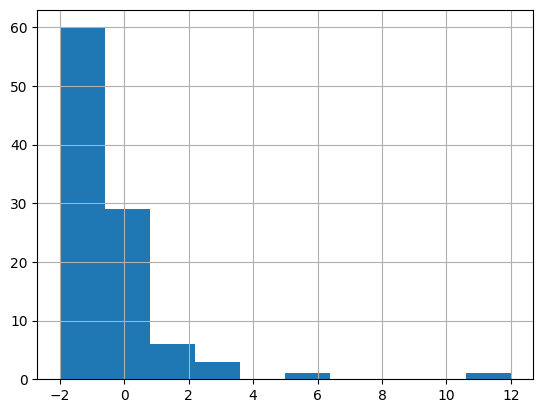

In [87]:
a = df[df['Matching'] == -2]['TOM Responses'].apply(lambda x: x.split('\n')[-1])
df['Matching'].hist()

In [88]:
df['Matching'].value_counts()

Matching
-1     31
-2     29
 0     29
 1      6
 3      3
 12     1
 6      1
Name: count, dtype: int64

In [1]:
# df[df['P2_Locs'].apply(lambda x: len(x) > 3)]

In [124]:
df.head()

,Unnamed: 0,Story,Label,P1,P2,Last,TOM Responses,P2_Locs,Correct,Matching
0,0,Georgia enters room_2. Charlie enters room_2. ...,room_3,Danny,Alice,the_hallway,"<think>\nOkay, let's try to figure out where D...","[room_2, room_3, the_hallway]",True,-1
1,0,Charlie enters room_4. Charlie enters room_3. ...,room_5,Alice,Bob,room_4,"<think>\nOkay, let's try to figure out where A...","[room_1, room_5, room_4]",True,-1
2,0,Danny enters room_1. Charlie enters room_2. Al...,room_2,Frank,Danny,the_hallway,"<think>\nOkay, let's try to figure out where F...","[room_1, room_5, room_2, the_hallway]",True,-1
3,0,Alice enters room_2. Bob enters room_1. Alice ...,room_1,Edward,Charlie,room_2,"<think>\nOkay, let's try to figure out where E...","[room_4, room_1, room_2]",True,-1
4,0,Georgia enters room_4. Edward enters room_4. B...,the_hallway,Edward,Danny,room_4,"<think>\nOkay, let's try to figure out where E...","[room_4, room_3, the_hallway, room_4]",True,-1


In [125]:
df.iloc[5]

Unnamed: 0                                                       0
Story            Georgia enters room_4. Edward enters room_1. F...
Label                                                       room_2
P1                                                           Frank
P2                                                             Bob
Last                                                   the_hallway
TOM Responses    <think>\nOkay, let's try to figure out where F...
P2_Locs                              [room_1, room_2, the_hallway]
Correct                                                       True
Matching                                                        -1
Name: 5, dtype: object

In [127]:
df[df['Matching'] == -2]

,Unnamed: 0,Story,Label,P1,P2,Last,TOM Responses,P2_Locs,Correct,Matching
6,0,Charlie enters room_1. Edward enters room_2. E...,room_3,Alice,Georgia,room_4,"<think>\nOkay, let's try to figure out where A...","[room_2, room_3, room_4]",False,-2
8,0,Danny enters room_2. Frank enters room_2. Char...,room_2,Charlie,Edward,the_hallway,"<think>\nOkay, let's try to figure out where C...","[room_1, room_2, the_hallway]",False,-2
9,0,Georgia enters room_4. Charlie enters room_1. ...,room_1,Alice,Danny,the_hallway,"<think>\nOkay, let's try to figure out where A...","[room_4, room_1, the_hallway]",False,-2
36,0,Edward enters room_1. Bob enters room_4. Bob e...,room_5,Alice,Charlie,room_2,"<think>\nOkay, let's try to figure out where A...","[room_1, room_5, room_2]",False,-2
47,0,Georgia enters room_1. Georgia enters room_2. ...,the_hallway,Danny,Bob,room_1,"<think>\nOkay, let's try to figure out where D...","[room_4, room_3, the_hallway, room_1]",False,-2
62,0,Danny enters room_4. Bob enters room_4. Bob en...,room_2,Edward,Charlie,room_3,"<think>\nOkay, let's try to figure out where E...","[room_1, room_2, room_3]",False,-2
72,0,Frank enters room_1. Edward enters room_2. Fra...,room_5,Danny,Georgia,room_2,"<think>\nOkay, let's try to figure out where D...","[room_4, room_5, room_2]",False,-2
76,0,Bob enters room_1. Alice enters room_2. Danny ...,the_hallway,Edward,Danny,room_4,"<think>\nOkay, let's try to figure out where E...","[room_4, room_3, the_hallway, room_4]",False,-2
82,0,Georgia enters room_1. Alice enters room_2. Ge...,room_3,Edward,Danny,room_4,"<think>\nOkay, let's try to figure out where E...","[room_2, room_3, room_4]",False,-2
87,0,Georgia enters room_1. Bob enters room_4. Bob ...,room_4,Frank,Georgia,room_3,"<think>\nOkay, let's try to figure out where F...","[room_1, room_5, room_4, room_3]",False,-2


In [15]:
outs= df.apply(lambda x: compute_score_unsure(x['Tom_Label'], x['TOM Responses']), axis=1)
#print(outs)
known = [k for k in outs if k == 'True' or k == 'False']
unknown = [k for k in outs if k != 'True' and k != 'False']
print(sum([1 for k in known if k == 'True']))
print(len(unknown))
print([i for i in range(len(outs)) if outs.iloc[i] == 'True'])
# for i in range(len(outs)):
#     if outs.iloc[i] == 'False':
#         clean_out = df["TOM Responses"].iloc[i].split('<think>')[-1]
#         print(f'Index {i}')
#         print("\n-////==============////-\n")

15
0
[11, 13, 31, 32, 40, 50, 58, 60, 69, 78, 81, 84, 89, 91, 92]


In [ ]:
df['Story'].iloc[8]

'Bob enters room_1. Alice enters room_4. Edward enters room_4. Danny enters room_4. Frank enters room_1. Bob enters room_5. Charlie enters room_1. Alice enters room_5. Charlie enters room_2. Danny enters room_3. Edward enters room_3. Edward enters room_4. Alice enters room_2. Charlie enters room_3. Alice enters room_3. Charlie enters room_4. Charlie enters room_1. Charlie enters room_2. Bob enters room_4. Alice enters room_2. Bob enters room_3. Alice enters room_3. Edward enters the_hallway. Alice enters the_hallway. Bob enters the_hallway. Charlie enters room_1. Alice enters room_1. Alice enters room_2. Frank enters room_5. Bob enters room_2. Charlie enters the_hallway. Alice enters room_3. Bob enters room_3. Alice enters room_2. Frank enters room_4. Alice enters room_1. Frank enters room_5. Alice enters room_2. Frank enters room_1. Alice enters room_1. Charlie enters room_4. Alice enters room_2. Alice enters room_3. Frank enters room_2. Frank enters the_hallway. Charlie enters room_5

[]

In [ ]:
print(df['TOM Responses'].iloc[13])
print('=-=-=-=-=-')
print(df['TOM Label'].iloc[13])

In [ ]:
46+8

54

In [ ]:
df['WM Responses Objects'].apply(lambda x: x.split('\n')[-1])

0                                               hallway
1                                               hallway
2                                                room_5
3                                                room_4
4                                                room_2
                            ...                        
95                                            A: room_3
96                                              hallway
97                                              hallway
98                                               room_5
99    However, The apple, The ball, and The bottle w...
Name: WM Responses Objects, Length: 100, dtype: object

In [ ]:
outs= df.apply(lambda x: compute_score_unsure(x['WM_Label'], x['WM Responses Humans']), axis=1)
known = [k for k in outs if k == 'True' or k == 'False']
unknown = [k for k in outs if k != 'True' and k != 'False']
print(sum([1 for k in known if k == 'True']))
print(len(unknown))
for i in range(len(outs)):
    if outs.iloc[i] != 'True' and outs.iloc[i] != 'False':
        clean_out = outs.iloc[i].split('<think>')[-1]
        print(f'{clean_out}')
        print(f'Index {i}')
        print("\n-////==============////-\n")

19
0


In [ ]:
outs= df.apply(lambda x: compute_score_unsure(x['WM_Label'], x['WM Responses Objects']), axis=1)
known = [k for k in outs if k == 'True' or k == 'False']
unknown = [k for k in outs if k != 'True' and k != 'False']
print(sum([1 for k in known if k == 'True']))
print(len(unknown))
for i in range(len(outs)):
    if outs.iloc[i] != 'True' and outs.iloc[i] != 'False':
        clean_out = outs.iloc[i].split('<think>')[-1]
        print(f'{clean_out}')
        print(f'Index {i}')
        print("\n-////==============////-\n")

29
0


In [ ]:
df.apply(lambda x: compute_score_unsure(x['WM_Label'], x['WM Responses Objects']), axis=1)

0     False
1     False
2     False
3     False
4     False
      ...  
95    False
96    False
97    False
98    False
99    False
Length: 100, dtype: object

In [ ]:
def clean_r1_response(response):
    if 'Answer:' in response:
        response = response.split('Answer:')[-1]
    elif 'A:' in response:
        response = response.split('A:')[-1]
    elif 'Conclusion:' in response:
        response = response.split('Conclusion:')[-1]
    if '\n' in response:
        response = response.split('\n')[0]
    elif '**' in response:
        response = response.replace('*','')
    return response
df['Clean TOM'] = df['TOM Responses'].apply(lambda x: clean_r1_response(x))
df['Clean WM'] = df['WM Responses'].apply(lambda x: clean_r1_response(x))


True